# Adversarial Examples - googleNet on ImageNet

GoogleNet network on ImageNet style dataset with 1000 examples [?].

**Content**

1. Model and data
2. Predict function
3. Adversarial examples:

&emsp; 3.1 FGSM (untargeted)

&emsp; 3.2 BIM (untargeted)

&emsp; 3.3 Extension of BIM (targeted)

&emsp; 3.4 DeepFool (?)

In [12]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset
import torch.nn.functional as F
from torchvision import transforms

plt.rcParams['figure.figsize'] = (20.0, 10.0)

from IPython.display import clear_output

## 1. Load data and model

First we load the model and data.


### 1.1 Model

We use the trained googleNet [2]. It is available through the `Torchvision` library. It expects the data to be 3 channel RGB with a size of at least 224. The data has to be scaled into the range $[0, 1]$ and then centered, see [here](https://pytorch.org/hub/pytorch_vision_googlenet/). These steps are implemented in 1.2.

In [2]:
## Load model and data
model = models.googlenet(pretrained=True)
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [3]:
def idx_to_name(idx):
    '''
    Converts the output class index from the googleNet to the respective name.
    
    Input:
    idx  -- Class index as integer
    
    Returns:
    name -- Class names corresponding to idx as string
    '''
    
    ## Load dictionary from file    
    names = pd.read_csv("./data/ImageNet_subset/categories.csv")
    
    ## Retrieve class name for idx
    name = names.iloc[idx]["CategoryName"]
    
    return name

### 1.2 Data

As data we use the development set from [3]. It is a subset similar to the ImageNet dataset [4] on which the model from 1.1 is trained. It consists of only 1000 images of various classes. That means the dataset is small enough to be handled on a cpu.

The data can be obtained from the competition [NIPS 2017: Adversarial Learning Development Set](https://www.kaggle.com/google-brain/nips-2017-adversarial-learning-development-set#categories.csv) which was hosted on [Kaggle](http://www.kaggle.com).

In [4]:
class ImageNetSubset(Dataset):
    '''Imports subset of the ImageNet dataset from the Kaggle competion'''
    
    def __init__(self, csv_file, root_dir, transform=None):
        '''
        Args:
        csv_file (string)              -- Path to the csv file with metadata like labels and fileId.
        root_dir (string)              -- Directory with all the images.
        transform (callable, optional) -- Optional transform to be applied on a sample.
        '''

        self.images_meta = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
               
    def __len__(self):
        return len(self.images_meta)
    
    def __getitem__(self, idx):     
        image_path = self.root_dir
        image_name = self.images_meta["ImageId"][idx]
        label = self.images_meta["TrueLabel"][idx]
        
        ## Load image
        image = Image.open(image_path + image_name + ".png")
        
        if self.transform is not None:
            image = self.transform(image)
            
        ## Format label. Labels in dataset are 1 indexed but 0 indexed in model. Make all 0 indexed.
        label = torch.tensor(label-1, dtype=torch.long)
        
        ## Move data to cuda if available
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        image = image.to(device)
        label = label.to(device)
        
        
        return image, label

In [5]:
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

data_loader = torch.utils.data.DataLoader(
    ImageNetSubset("data/ImageNet_subset//dev_dataset.csv", "data/ImageNet_subset//images/", transform=preprocess))

**Preprocess data**

The image has to be cropped, centered as well as normalized. Since the model has been trained with mini batch gradient descent, we add the batch dimension.

In [6]:
def show_tensor_image(tensor):
    '''
    De-normalizes an image as a tensor and converts it back into an 8bit image object.
    
    Inputs:
    tensor -- PyTorch tensor of shape (1, 3, 224, 224)
    
    Returns:
    image  -- De-normalized image object
    '''
    
    ## Detach computation graph and remove batch dimension
    tensor = tensor.detach().clone()    
    tensor.squeeze_()
    
    ## De-normalize tensor image
    invert_preprocess = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
    ])
      
    image = invert_preprocess(tensor)      
    image = np.array(image.detach())
    
    ## Rescale to range 0-255 and convert datatype into 8bit
    image = image * 255    
    image = np.uint8(image)
    
    ## Swap axes to get the expected shape (224, 224, 3)
    image = np.swapaxes(image, 0, 2)
    
    ## Rotate image and convert to image object
    for i in range(3):
        image = np.rot90(image)
    
    image  = Image.fromarray(image)
    
    ## Show image
    plt.imshow(image)
        
    return image

## 2. Predict

In [7]:
def predict(model, image, target_label, return_grad=False):
    '''
    Predicts the class of the given image and compares the prediction with the provided label.
    
    Inputs:
    model           -- net
    image           -- Input image as tensor of shape (1, 3, 224, 224)
    target_label    -- Target label as tensor of shape (1)
    return_grad     -- Returns gradient if set True
    
    Returns:
    gradient        -- None if return_grad=False. Otherwise the gradient from the prediction 
                       as a tensor of shape ()
    correct         -- Integer of value 1 if class is correct, otherwise 0
    confidence      -- Confidence of prediction
    predicted_label -- Predicted label as integer
    '''      
        
    if return_grad == True:
        image.requires_grad=True
        prediction = model(image)
               
        # Zero gradients
        model.zero_grad()

        # Calculate loss using the class index for pandas and get gradient
        loss = F.nll_loss(prediction, target_label)
        loss.backward()
        gradient = image.grad.data
        
    else:           
        gradient = None
        with torch.no_grad():
            prediction = model(image)
    
    ## Calculate if prediction is correct
    class_index = np.argmax(prediction.cpu().detach().numpy())
    
    if class_index == target_label:
        correct = 1
        
    else:
        correct = 0
     
    
    ## Get class index and confidence    
    prediction = torch.nn.functional.softmax(prediction[0].cpu().detach(), dim=0).numpy()
    confidence = prediction[class_index]
    
    ## Get class name from the predicted index
    predicted_label = np.argmax(prediction)
     
    return gradient, correct, confidence, predicted_label

## 3. Generate and Use Adversarial Examples

We now construct adversarial examples and use them to attack the network. We look at three untargeted attacks first. Finally, we investigate a targeted attack type. For more general information refer to the project overview.

To evaluate an individual adversarial example and to see it next to the clean image from which it has been constructed we define the function `plot_examples`.

In [8]:
def plot_examples(image_clean, image_adv, conf_clean, conf_adv, label_clean, label_adv, label_target):
    '''
    Plots the clean and adversarial image side-by-side. Prints predicted labels and confidences for both.
    
    Inputs:
    image_clean     -- Clean image as tensor of shape (1, 1, 28, 28)
    image_adv       -- Adversarial image as tensor of shape (1, 1, 28, 28)
    conf_clean      -- Confidence for the clean image
    conf_adv        -- Confidence for the adversarial image
    label_clean     -- Predicted label from the clean image
    label_adv       -- Predicted label from the adversarial image
    label_target    -- Target label as tensor of shape (1)
    '''
   
    ## Get label names from index
    name_target = idx_to_name(label_target.detach().numpy()[0])
    name_clean = idx_to_name(label_clean)
    name_adv = idx_to_name(label_adv)

    ## Text
    print("\t\t\tClean image\t Adversarial image\n")    
    print("Actual class: \t\t{}\t\t\t{}".format(name_target, name_target ))
    print("Predicted class: \t{}\t\t\t{}".format(name_clean, name_adv ))
    print("Confidence: \t\t{:.2f}%\t\t\t\t{:.2f}%\n".format(conf_clean*100, conf_adv*100))
    
    ## Plots
    plt.subplot(121)
    plt.title("Clean example", fontsize=30)
    show_tensor_image(image_clean)
    plt.subplot(122)
    plt.title("Adversarial example", fontsize=30)
    show_tensor_image(image_adv)

In [9]:
def compare_examples_fgsm(epsilon, idx):
    '''
    Generates an example using FGSM. Prints infos and plots clean and adversarial image side-by-side
    
    Inputs:
    epsilon -- Hyperparameter for FGSM
    idx     -- Index of sample   
    '''
    
    ## Get data
    image_clean, target_label = data_loader.dataset[idx]
    image_clean.unsqueeze_(0)
    target_label.unsqueeze_(0)
    image_clean = image_clean.cpu()
    target_label = target_label.cpu()
    model.cpu()

    ## Predict clean example
    gradient, _, conf_clean, label_clean = predict(model, image_clean, target_label, return_grad=True)

    ## Compute adversarial image and predict for it.
    image_adv = apply_fgsm(image_clean, epsilon, gradient)
    _, _, conf_adv, label_adv = predict(model, image_adv, target_label, return_grad=False)

    ## Plot
    plot_examples(image_clean, image_adv, conf_clean, conf_adv, label_clean, label_adv, target_label)

### 3.1 Fast Gradient Sign Method


**TODO**
Add better description!!!!!!


This method by [1] generates adversarial examples quickly. It computes a step of gradient descent and moves one step of magnitude $\epsilon$ into the direction of this gradient:

\begin{equation}
\tag{1.1}
\widetilde{x} = x + \eta
\end{equation}

\begin{equation}
\tag{1.2}
\eta = \epsilon \cdot sign(\nabla_{x} J(\Theta, x, y))
\end{equation}



In [10]:
def apply_fgsm(image, epsilon, grad_x):
    '''
    Generates adversarial image from the input image using the Fast Gradient Sign Method (FGSM).
    
    Inputs:
    image       -- Image data as tensor
    epsilon     -- Hyperparameter
    grad_x      -- Gradient of the cost with respect to x
    
    Returns:
    image_tilde -- Adversarial image as tensor
    '''
    
    ## Compute eta part
    eta = epsilon * grad_x.sign()
    
    ## Apply perturbation
    image_tilde = image + eta    
    
    ## Clip image to maintain the range [0, 1]
    #image_tilde = torch.clamp(image_tilde, image.detach().min(), image.detach().max())
    
    return image_tilde

			Clean image	 Adversarial image

Actual class: 		church, church building			church, church building
Predicted class: 	church, church building			patio, terrace
Confidence: 		72.14%				38.07%



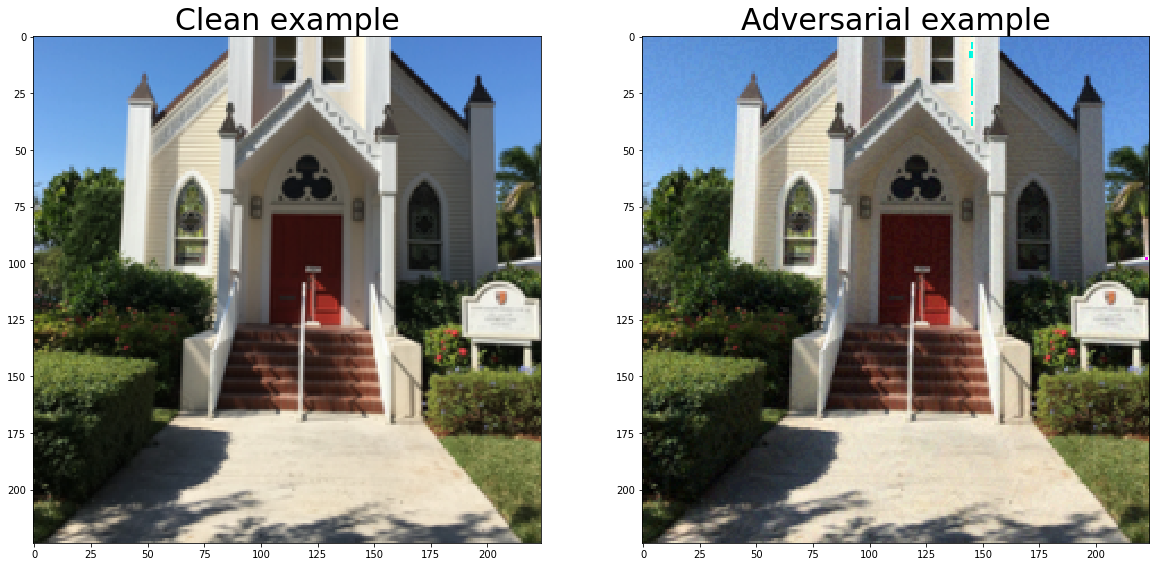

In [13]:
## Random example for smaller epsilon
epsilon = 12/255
idx = 825

compare_examples_fgsm(epsilon, idx)

			Clean image	 Adversarial image

Actual class: 		canoe			canoe
Predicted class: 	canoe			speedboat
Confidence: 		80.08%				3.44%



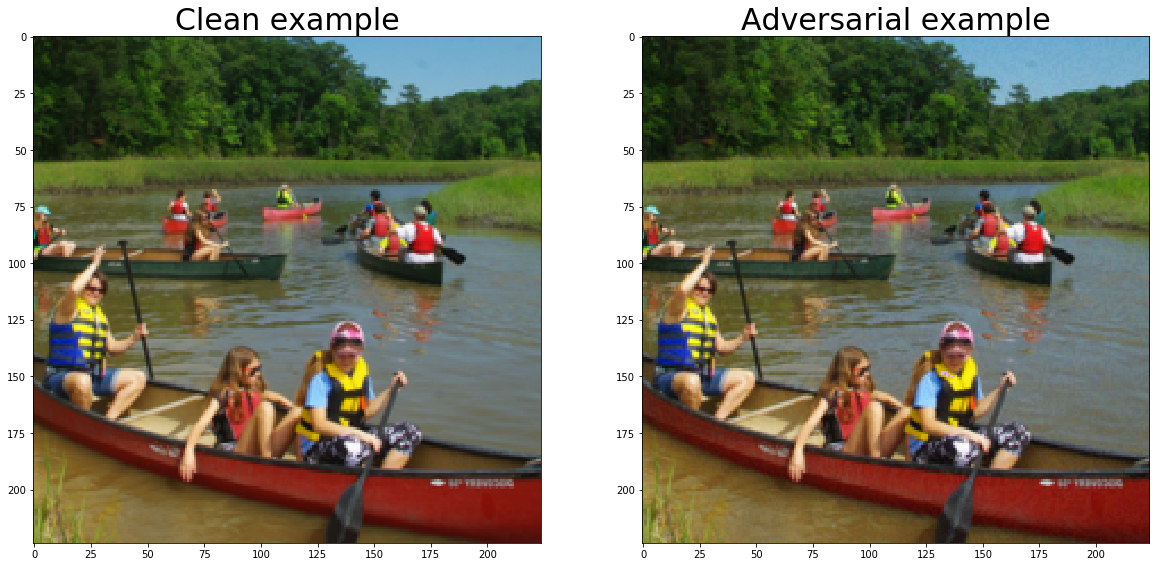

In [14]:
## Random example for larger epsilon
epsilon = 12/255
idx = 440

compare_examples_fgsm(epsilon, idx)

It can be seen that from a value of around $\epsilon = \frac{10}{255}$ the pertubation becomes visible to the human eye. Note that the model predicts a different class here with a very low confidence.

In [ ]:
## Run on all 10000 examples
epsilons = [0, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255, 90/255]

accuracy = []
confidence = []

accuracy_adversarial = []
confidence_adversarial = []

for epsilon in epsilons:
   
    acc_sub = []
    conf_sub = []
    acc_sub_adver = []
    conf_sub_adver = []
    i = 1
    
    for image_as_tensor, label in data_loader:      
        clear_output(wait=True)
        print("Running for epsilon {:.2f}".format(epsilon))
        print("Sample: "+ str(i))
        print("Accuracy adversarial: {:.2f}".format(np.mean(acc_sub_adver)))
        print("Confidence adversarial: {:.2f}".format(np.mean(conf_sub_adver)))
        
        ## Predict with clean image
        gradient, acc, conf, _ = predict(model, image_as_tensor, label, return_grad=True)
        acc_sub.append(acc)
        conf_sub.append(conf)

        ## Predict with adversarial image
        perturbed_data = apply_fgsm(image_as_tensor, epsilon, gradient)
        _, acc, conf, _ = predict(model, perturbed_data, label)
        acc_sub_adver.append(acc)
        conf_sub_adver.append(conf)
        i += 1
        
    ## Add accuracies and confidences for clean and adversarial example
    accuracy.append(np.mean(acc_sub))
    confidence.append(np.mean(conf_sub))
    accuracy_adversarial.append(np.mean(acc_sub_adver))
    confidence_adversarial.append(np.mean(conf_sub_adver))

   
## Save results
result = pd.DataFrame()
e = np.array(epsilons) * 255
result["Epsilon_255"] = e
result["Accuracy"] = accuracy_adversarial
result["Confidence"] = confidence_adversarial
#result.to_csv("results/googleNet_ImageNet_FGSM_2.csv")

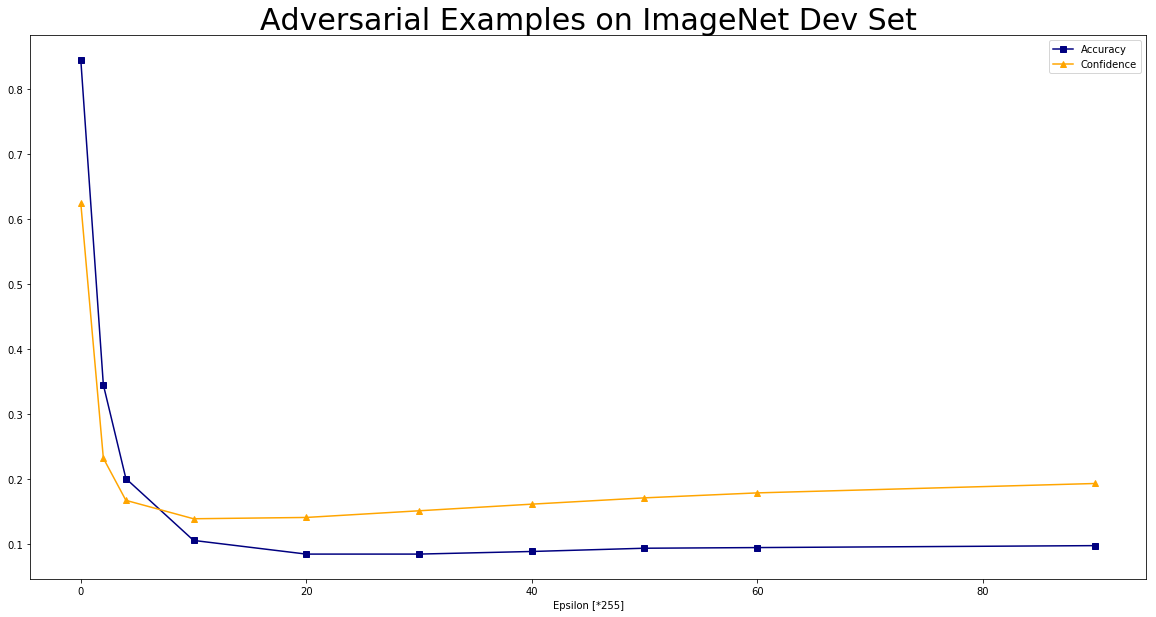

In [14]:
plt.plot(e, accuracy_adversarial, "s-", color="navy", label="Accuracy")
plt.plot(e, confidence_adversarial, "^-", color="orange", label="Confidence")
plt.xlabel("Epsilon [*255]")

plt.title("Adversarial Examples on ImageNet Dev Set", fontsize=30)
plt.legend()
#plt.show()

#plt.savefig("./plots/googleNet_ImageNet/Adversarial_Examples_ImageNet_FGSM.pdf")
#plt.savefig("./plots/googleNet_ImageNet/Adversarial_Examples_ImageNet_FGSM.png")

### 3.2 Basic Iterative Method (BIM)

In the previous section we found examples which are classified as the wrong class at a high confidence using the FGSM. A downside of FGSM is that it can be used for untargeted attacks only [2]. Another downside is that



BIM requires the following function, which clips pixel values of an image $X^\prime$:

**TODO**
Fix explanation!!

Similar to the fast method we update the pixel values:

\begin{equation}
\tag{2.1}
\widetilde{X}_{n+1} = Clip_{X, \epsilon} \{ \widetilde{X}_{n} + \alpha sign(\nabla_{X} J(\widetilde{X}_{n}, Y_{true})) \}
\end{equation}




Here, the Clip function is defined as:

\begin{equation}
\tag{2.2}
Clip_{X, \epsilon} \{ X^\prime \} (x, y, z) = min\{ 255, X(x, y, z) + \epsilon, max\{0, X(x, y, z)-\epsilon, X^\prime(x, y, z) \} \}
\end{equation}

For the implementation we initialize:

\begin{equation}
\tag{2.3}
\widetilde{X}_{0} = X
\end{equation}

For the implementation we do for the number of iterations `n`:


a) Compute $ X^\prime = \widetilde{X}_{n} + \alpha sign(\nabla_{X} J(\widetilde{X}_{n}, Y_{true}))$ as used in equation (2.1)

b) Compute $ X(x, y, z) + \epsilon $ and $ X(x, y, z) - \epsilon $

c) Evaluate equation (2.2) using steps a) and b)

$max\{0, X(x, y, z)-\epsilon, X^\prime(x, y, z) \}$ (?)

d) Retrieve updated adversarial image $\widetilde{X}_{1}$ as given in equation (2.1)

Values for the hyper parameters given in [2]:

- $\alpha = 1$

- Number of iterations: $min(4+\epsilon, 1.25 \cdot \epsilon)$

- $\epsilon $

In [28]:
def apply_BIM(model, image, label, alpha, epsilon, num_iterations=2):
    '''
    Applies given number of steps of the Basic Iterative Method (BIM) attack on the input image.
    
    Inputs:
    model          -- Model under attack
    image          -- Image data as tensor of shape (1, 3, 224, 224)
    label          -- Label from image of shape (1)
    alpha          -- Hyperparameter for iterative step
    epsilon        -- Hyperparameter for sign method
    num_iterations -- Number of iterations to perform
    
    Returns:
    image_adver    -- Adversarial image as tensor
    '''
    
    ## Convert label to torch tensor
    #label = torch.tensor(label, dtype=torch.long)   

    ## Check input image and label shapes
    assert(image.shape == torch.Size([1, 3, 224, 224]))
    assert(label.shape == torch.Size([1]))
    
    ## Initialize adversarial image as image according to equation (3)
    image_adver = image.clone()    
    #image_adver.requires_grad=True
    
    for i in range(num_iterations):
        
        ## Make a copy and detach so the computation graph can be constructed
        image_adver = image_adver.clone().detach()
        image_adver.requires_grad=True
        
        ## Compute cost with example image_adersarial        
        #image_adver.retain_grad=True
        
        pred = model(image_adver)
        
        #class_index = np.argmax(pred.detach().numpy())
        
        loss = F.nll_loss(pred, label)        
        model.zero_grad()        
        loss.backward()        
        grad_x = image_adver.grad.data       
        
        ## Checks
        assert(image_adver.grad is not None)
        
        
        ## Compute X_prime according to equation (1)
        image_prime = image_adver + alpha * grad_x.detach().sign()
        assert(torch.equal(image_prime, image_adver) == False)
    
        ## Apply clip function to image_prime as in equation (2)       
        image_plus = image + epsilon
        image_minus = image - epsilon
        assert(torch.equal(image_plus, image) == False)
        
        # Equation 1.2
        third_part_1 = torch.max(image_minus, image_prime)
        third_part = torch.max(torch.tensor(0, dtype=torch.float), third_part_1)
              
        # Equation (2)
        image_adver = torch.min(image_plus, third_part)                 
        image_adver = torch.min(torch.tensor(255, dtype=torch.float), image_adver)                        

    
    return image_adver

In [31]:
def compare_examples_bim(alpha, epsilon, idx):
    '''
    Generates an example using BIM. Prints infos and plots clean and adversarial image side-by-side.
    
    Inputs:
    epsilon -- Hyperparameter for BIM
    alpha   -- Hyperparameter for BIM
    idx     -- Index of sample   
    '''
    
    num_iterations = int(np.min([np.ceil(epsilon*4), np.ceil(1.25+epsilon)]))
    print("Number of iterations: " + str(num_iterations))
    
    
    ## Get data
    image_clean, target_label = data_loader.dataset[idx]
    image_clean.unsqueeze_(0)
    target_label.unsqueeze_(0)

    image_adv = apply_BIM(model, image_clean, target_label, alpha, epsilon, num_iterations=num_iterations)

    ## Predictions
    _, _, conf_clean, label_clean = predict(model, image_clean, target_label)
    _, _, conf_adv, label_adv = predict(model, image_adv, target_label)

    ## Plot
    plot_examples(image_clean, image_adv, conf_clean, conf_adv, label_clean, label_adv, target_label)

Number of iterations: 1
			Clean image	 Adversarial image

Actual class: 		coral reef			coral reef
Predicted class: 	coral reef			rock crab, Cancer irroratus
Confidence: 		85.77%				7.19%



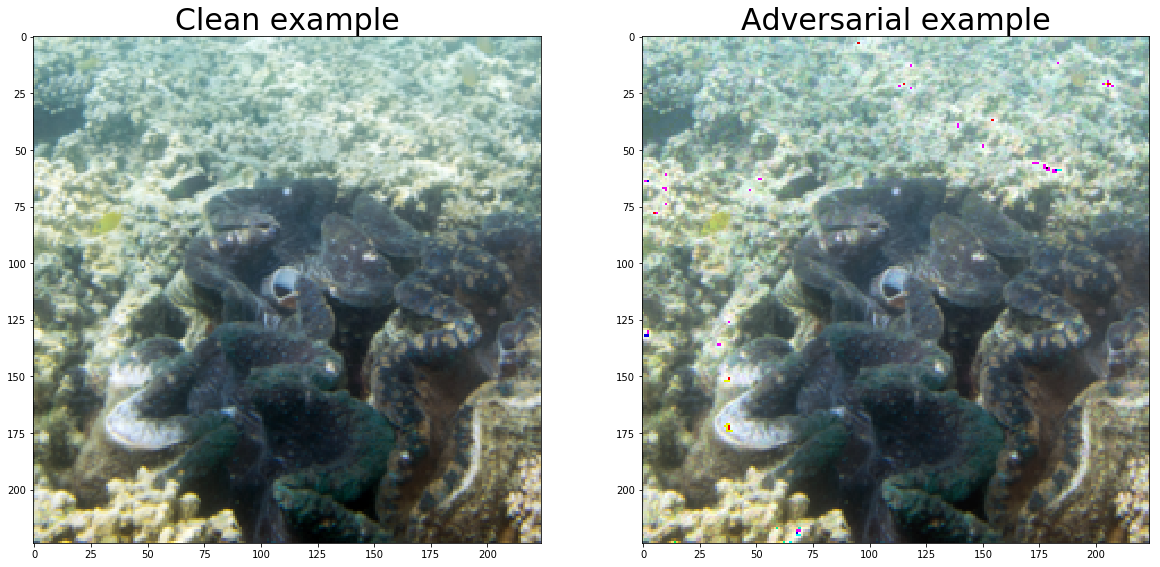

In [46]:
idx = 298
epsilon = 30/255 ## 
alpha = 1 # As in the paper

compare_examples_bim(alpha, epsilon, idx)

Number of iterations: 1
			Clean image	 Adversarial image

Actual class: 		canoe			canoe
Predicted class: 	canoe			canoe
Confidence: 		80.08%				23.56%



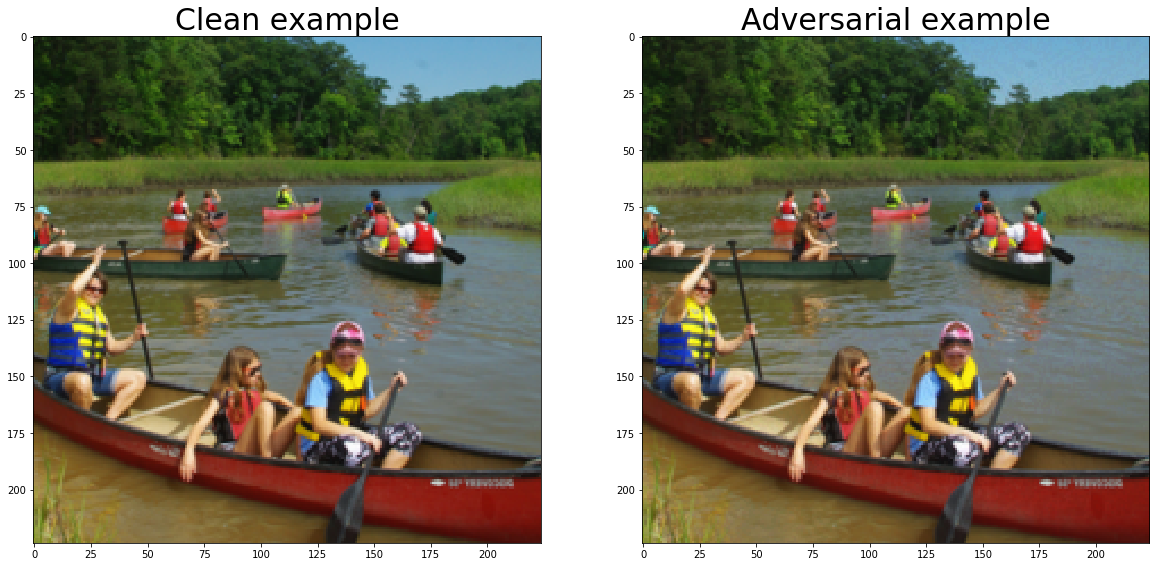

In [48]:
idx = 440
epsilon = 10/255 ## 
alpha = 1 # As in the paper

compare_examples_bim(alpha, epsilon, idx)

In [ ]:
## BIM: Run on all 10000 examples
epsilons = [0, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255, 90/255]


alpha = 1 # As in the paper
num_iterations = int(np.min([np.ceil(epsilon*4), np.ceil(1.25+epsilon)]))
print("Number of iterations: " + str(num_iterations))


num_iter = []

accuracy = []
confidence = []

accuracy_adversarial = []
confidence_adversarial = []

## Move model GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)


for epsilon in epsilons:
   
    num_iterations = int(np.min([np.ceil(epsilon*4), np.ceil(1.25+epsilon)]))
    num_iter.append(num_iterations)
    
    acc_sub = []
    conf_sub = []
    acc_sub_adver = []
    conf_sub_adver = []
    i = 1
    
    for image_clean, label in data_loader:      
        clear_output(wait=True)
        print("Running for epsilon {:.2f}".format(epsilon))
        print("Sample: " + str(i))
        print("Number of iterations: " + str(num_iterations))
        print("Average adv. accuracy: {:.2f}\nAverage adv. confidence: {:.2f}".format(np.mean(acc_sub_adver), np.mean(np.mean(conf_sub_adver) )) )
        
        ## Predict with clean image
        _, acc, conf, _ = predict(model, image_clean, label)
        acc_sub.append(acc)
        conf_sub.append(conf)

        ## Predict with adversarial image
        image_adversarial = apply_BIM(model, image_clean, label, alpha, epsilon, num_iterations=num_iterations)
        _, acc, conf, _ = predict(model, image_adversarial, label)
        acc_sub_adver.append(acc)
        conf_sub_adver.append(conf)
        i += 1

    ## Add accuracies and confidences
    accuracy.append(np.mean(acc_sub))
    confidence.append(np.mean(conf_sub))
    accuracy_adversarial.append(np.mean(acc_sub_adver))
    confidence_adversarial.append(np.mean(conf_sub_adver))


## Save results
result = pd.DataFrame()
e = np.array(epsilons) * 255
result["Epsilon_255"] = e
result["Num_Iter"] = num_iter
result["Accuracy"] = accuracy_adversarial
result["Confidence"] = confidence_adversarial
result.to_csv("results/googleNet_ImageNet_BIM_2.csv")

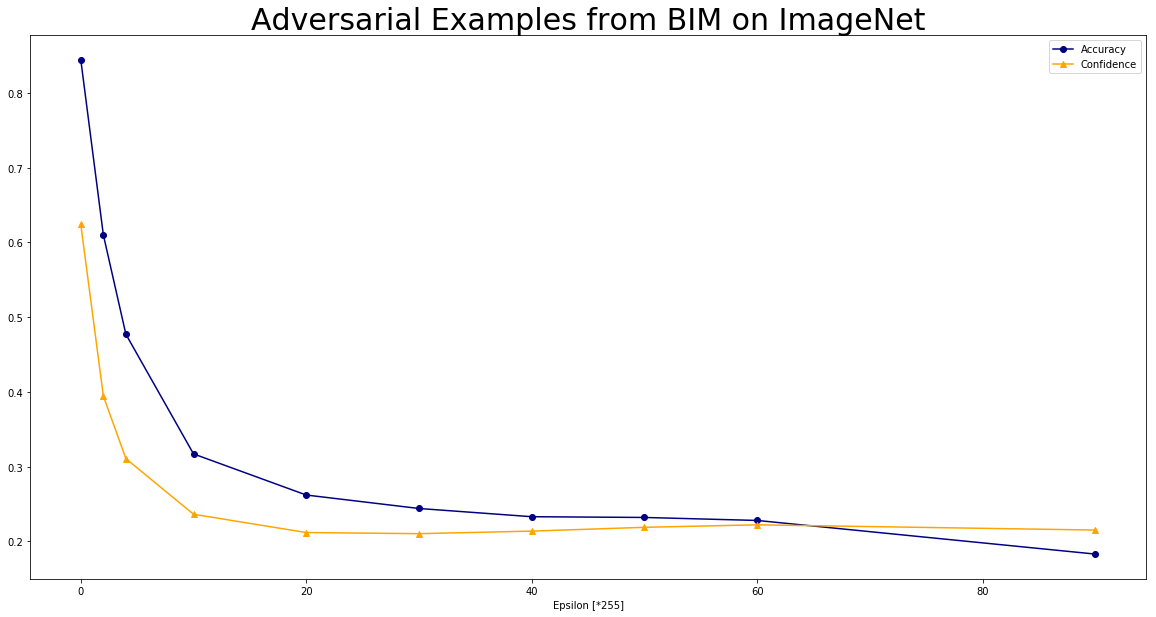

In [69]:
## Plot
plt.plot(e, accuracy_adversarial, "o-", color="navy", label="Accuracy")
plt.plot(e, confidence_adversarial, "^-", color="orange", label="Confidence")
plt.xlabel("Epsilon [*255]")

plt.title("Adversarial Examples from BIM on ImageNet", fontsize=30)
plt.legend()
#plt.show()

plt.savefig("plots/googleNet_ImageNet/Adversarial_Examples_ImageNet_BIM.pdf")
plt.savefig("plots/googleNet_ImageNet/Adversarial_Examples_ImageNet_BIM.png")

### 3.3 Iterative Least-Likely Class Method

### 3.4 DeepFool

## 4. Conclusions

The average accuracy drops quickly for even small values of $\epsilon$. So does the confidence. Interestingly, the confidence increases slightl with increasing $\epsilon$ after droping singificantly at the beginning.



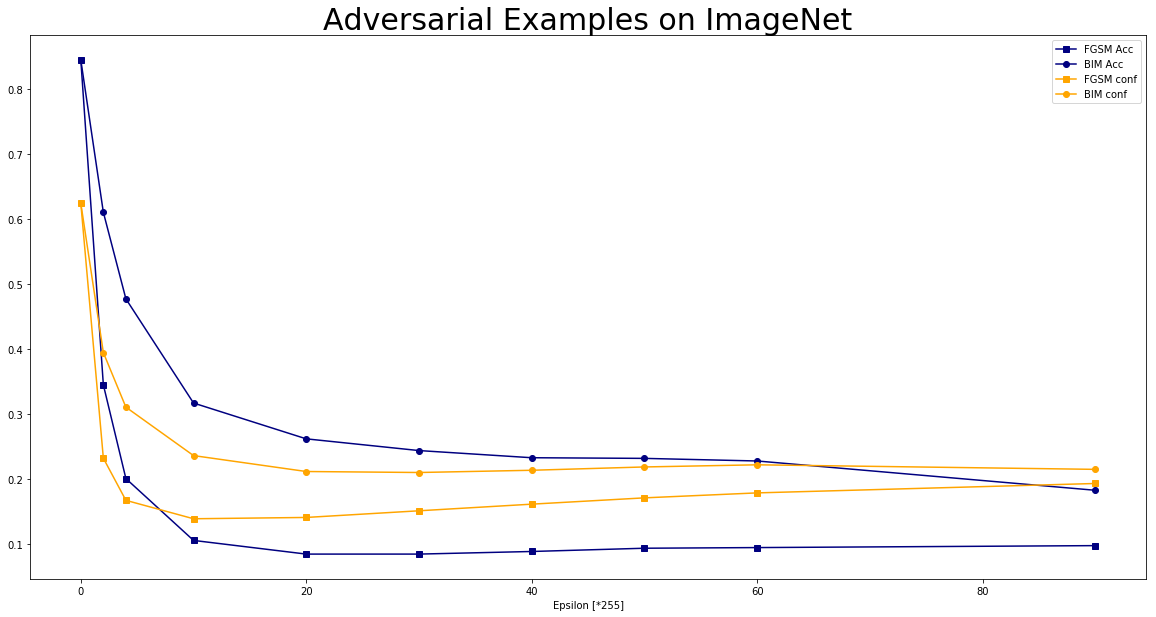

In [71]:
## Plot both FGSM and BIM
## Load data
fgsm = pd.read_csv("results/googleNet_ImageNet_FGSM.csv")
bim = pd.read_csv("results/googleNet_ImageNet_BIM.csv")

## Plot accuracy
plt.title("Adversarial Examples on ImageNet", fontsize=30)
plt.plot(fgsm["Epsilon_255"], fgsm["Accuracy"], "s-", color="navy", label="FGSM Acc")
plt.plot(bim["Epsilon_255"], bim["Accuracy"], "o-", color="navy", label="BIM Acc")

## Plot confidence
plt.plot(fgsm["Epsilon_255"], fgsm["Confidence"], "s-", color="orange", label="FGSM conf")
plt.plot(bim["Epsilon_255"], bim["Confidence"], "o-", color="orange", label="BIM conf")
plt.xlabel("Epsilon [*255]")
plt.legend()

plt.savefig("plots/googleNet_ImageNet/Adversarial_Examples_ImageNet_all.pdf")
plt.savefig("plots/googleNet_ImageNet/Adversarial_Examples_ImageNet_all.png")

## References

[1] &emsp; Goodfellow et al. (2015) *Explaining and Harnessing Adversarial Examples*

[2] &emsp; Szegedy et al. (2015) *Going Deeper with Convolutions*

[3] &emsp; Kurakin et al. (2018) *Adversarial Attacks and Defences Competition*

[4] &emsp; Russakovsky et al. (2015) *ImageNet Large Scale Visual Recognition Challenge*
